In [3]:
# import datacube
import numpy as np
import rioxarray as rio
import matplotlib.pyplot as plt
import pickle
#from sklearn.manifold import Isomap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline

from dask.distributed import Client
client = Client()
client

/home/javierlopatin/miniconda3/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46107 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:46107/status,
Dashboard: http://127.0.0.1:46107/status,Workers: 4
Total threads: 12,Total memory: 15.52 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36441,Workers: 4
Dashboard: http://127.0.0.1:46107/status,Total threads: 12
Started: Just now,Total memory: 15.52 GiB
Comm: tcp://127.0.0.1:39115,Total threads: 3
Dashboard: http://127.0.0.1:38125/status,Memory: 3.88 GiB
Nanny: tcp://127.0.0.1:43575,


In [4]:
# Load the raster data
img = rio.open_rasterio("Rasters/phenoshapeAll_masked.tif", chunks={'band': 1, 'x': 350, 'y': 350})
img

<xarray.DataArray (band: 52, y: 2243, x: 2530)>
dask.array<open_rasterio-2e319bea7c9c11d1de485ce126a20375<this-array>, shape=(52, 2243, 2530), dtype=float64, chunksize=(1, 350, 350), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
  * x            (x) float64 5.756e+05 5.756e+05 ... 6.009e+05 6.009e+05
  * y            (y) float64 4.234e+06 4.234e+06 ... 4.211e+06 4.211e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [ ]:
# chunk the data into smaller pieces using the terminal command
# usued only for KernelPCA, as it runs out of memory
#!gdal_retile.py -ps 512 512 -targetDir /home/javierlopatin/Documents/temp/WetlandPhenology/Rasters/tmp /home/javierlopatin/Documents/temp/WetlandPhenology/Rasters/phenoshapeAll_masked.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [5]:
# Convert the raster data to a 2D array and re-organize the data
data = img.stack(z=('y','x'))
data = data.transpose('z', 'band')
data 

<xarray.DataArray (z: 5674790, band: 52)>
dask.array<transpose, shape=(5674790, 52), dtype=float64, chunksize=(123970, 1), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
    spatial_ref  int64 0
  * z            (z) object MultiIndex
  * y            (z) float64 4.234e+06 4.234e+06 ... 4.211e+06 4.211e+06
  * x            (z) float64 5.756e+05 5.756e+05 ... 6.009e+05 6.009e+05
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [6]:
# delete rows with NaN values in data
data_na = data.dropna(dim='z', how='any')
data_na

<xarray.DataArray (z: 2792045, band: 52)>
dask.array<getitem, shape=(2792045, 52), dtype=float64, chunksize=(97397, 1), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
    spatial_ref  int64 0
  * z            (z) object MultiIndex
  * y            (z) float64 4.234e+06 4.234e+06 ... 4.211e+06 4.211e+06
  * x            (z) float64 5.839e+05 5.84e+05 ... 5.765e+05 5.765e+05
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [7]:
# select 100,000 random rows from the data_na. Reductions for KernelPCA, which is computationally expensive and run out of memory
data_na = data_na.isel(z=np.random.choice(data_na.z.size, 1000, replace=False))
data_na

/home/javierlopatin/miniconda3/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 18 times more chunks
  return self.array[key]


<xarray.DataArray (z: 1000, band: 52)>
dask.array<getitem, shape=(1000, 52), dtype=float64, chunksize=(2, 1), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
    spatial_ref  int64 0
  * z            (z) object MultiIndex
  * y            (z) float64 4.22e+06 4.228e+06 ... 4.217e+06 4.229e+06
  * x            (z) float64 5.961e+05 5.849e+05 ... 5.985e+05 5.835e+05
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [8]:
# Define the number of dimensions for the reduced space
n_components = 5

pipe = Pipeline([
        ('scale', StandardScaler()),
        #('reduce_dims', PCA(n_components=n_components)),
        ('reduce_dims', KernelPCA(n_components=n_components, kernel='rbf')),
        ])

pipe.fit(data_na)

: 

: 

In [ ]:
# save fitted model to disk for later use
pickle.dump(pipe, open("models/pipe_kernelPCA.pkl", "wb"))

In [9]:
pca_info = pipe.named_steps['reduce_dims']
#explained_variance = pca_info.explained_variance_ratio_
explained_variance = pca_info.eigenvalues_
print(explained_variance)

# save the results to a txt file
#np.savetxt('explained_variance_PCA.txt', explained_variance, delimiter=',')
#np.savetxt('explained_variance_kernelPCA.txt', explained_variance, delimiter=',')

[130.10361145  92.86229969  79.16408085  44.97729223  39.13078838]


2023-02-14 12:02:34,430 - tornado.application - ERROR - Uncaught exception GET /status/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='127.0.0.1:8787', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/home/javierlopatin/miniconda3/lib/python3.10/site-packages/tornado/websocket.py", line 954, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/home/javierlopatin/miniconda3/lib/python3.10/site-packages/tornado/web.py", line 3173, in wrapper
    return method(self, *args, **kwargs)
  File "/home/javierlopatin/miniconda3/lib/python3.10/site-packages/bokeh/server/views/ws.py", line 149, in open
    raise ProtocolError("Token is expired.")
bokeh.protocol.exceptions.ProtocolError: Token is expired.
ERROR:tornado.application:Uncaught exception GET /status/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='127.0.0.1:8787', method='GET', uri='/status/ws', versio

Text(0.5, 0, 'Number of components')

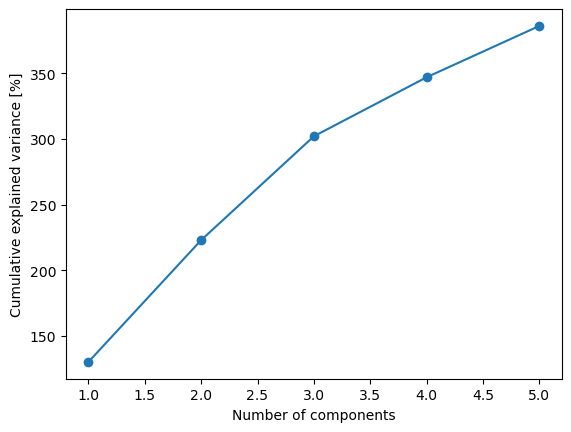

In [10]:
# plot the cumuative explained variance. X axis with intervals of 1
plt.plot(np.arange(1, n_components+1), np.cumsum(explained_variance), 'o-')
plt.ylabel('Cumulative explained variance [%]')
plt.xlabel('Number of components')
#plt.savefig('figures/PCA_cumulative_explained_variance.png', dpi=300)

In [11]:
# transform the encoded data to a 3D array
# template with the xarray shape
template = data[:, 1:(n_components+1)]
template
# assign the encoded data to the template
output_array = template.copy(data=data_reduced)
# unstack xarray to get the original shape
prediction = output_array.unstack()
prediction

<xarray.DataArray (band: 5, y: 2207, x: 2522)>
array([[[14.81494751, 14.81494751, 14.81494751, ..., 14.81494751,
         14.81494751, 14.81494751],
        [14.81494751, 14.81494751, 14.81494751, ..., 14.81494751,
         14.81494751, 14.81494751],
        [14.81494751, 14.81494751, 14.81494751, ..., 14.81494751,
         14.81494751, 14.81494751],
        ...,
        [14.81494751, 14.81494751, 14.81494751, ..., 14.81494751,
         14.81494751, 14.81494751],
        [14.81494751, 14.81494751, 14.81494751, ..., 14.81494751,
         14.81494751, 14.81494751],
        [14.81494751, 14.81494751, 14.81494751, ..., 14.81494751,
         14.81494751, 14.81494751]],

       [[-1.45548806, -1.45548806, -1.45548806, ..., -1.45548806,
         -1.45548806, -1.45548806],
        [-1.45548806, -1.45548806, -1.45548806, ..., -1.45548806,
         -1.45548806, -1.45548806],
        [-1.45548806, -1.45548806, -1.45548806, ..., -1.45548806,
         -1.45548806, -1.45548806],
...
        [-1.6223509 , -1.6223509 , -1.6223509 , ..., -1.6223509 ,
         -1.6223509 , -1.6223509 ],
        [-1.6223509 , -1.6223509 , -1.6223509 , ..., -1.6223509 ,
         -1.6223509 , -1.6223509 ],
        [-1.6223509 , -1.6223509 , -1.6223509 , ..., -1.6223509 ,
         -1.6223509 , -1.6223509 ]],

       [[ 0.78470941,  0.78470941,  0.78470941, ...,  0.78470941,
          0.78470941,  0.78470941],
        [ 0.78470941,  0.78470941,  0.78470941, ...,  0.78470941,
          0.78470941,  0.78470941],
        [ 0.78470941,  0.78470941,  0.78470941, ...,  0.78470941,
          0.78470941,  0.78470941],
        ...,
        [ 0.78470941,  0.78470941,  0.78470941, ...,  0.78470941,
          0.78470941,  0.78470941],
        [ 0.78470941,  0.78470941,  0.78470941, ...,  0.78470941,
          0.78470941,  0.78470941],
        [ 0.78470941,  0.78470941,  0.78470941, ...,  0.78470941,
          0.78470941,  0.78470941]]])
Coordinates:
  * y            (y) float64 4.233e+06 4.233e+06 ... 4.211e+06 4.211e+06
  * x            (x) float64 5.756e+05 5.757e+05 ... 6.008e+05 6.009e+05
  * band         (band) int64 2 3 4 5 6
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [18]:

## work arround for kernelPCA, as it runs out of memory

from tqdm import tqdm

# load the model from disk
pipe = pickle.load(open("pipe_kernelPCA.pkl", "rb"))

# list the chunks of raster data
raster_chunks = !ls /home/javierlopatin/Documents/temp/WetlandPhenology/Rasters/tmp/*.tif

for i in range(len(raster_chunks)):
    print(i+1, "of", len(raster_chunks))
    data = rio.open_rasterio(raster_chunks[i], chunks={'band': 1, 'x': 100, 'y': 100})
    data = data.stack(z=('y','x'))
    data = data.transpose('z', 'band')
    data.values = np.nan_to_num(data.values)
    data_reduced = pipe.transform(data)
    template = data[:, 1:(n_components+1)]
    output_array = template.copy(data=data_reduced)
    prediction = output_array.unstack()
    prediction.rio.to_raster("Rasters/tmp/PCA_" + str(i) + ".tif")

  0%|          | 0/25 [00:00<?, ?it/s]

0


  4%|▍         | 1/25 [00:18<07:24, 18.50s/it]

1


  8%|▊         | 2/25 [00:40<07:54, 20.63s/it]

2


 12%|█▏        | 3/25 [01:02<07:49, 21.35s/it]

3


 16%|█▌        | 4/25 [01:28<08:03, 23.05s/it]

4


 20%|██        | 5/25 [01:49<07:25, 22.26s/it]

5


 24%|██▍       | 6/25 [02:12<07:06, 22.47s/it]

6


 28%|██▊       | 7/25 [02:35<06:51, 22.84s/it]

7


 32%|███▏      | 8/25 [02:58<06:29, 22.90s/it]

8


 36%|███▌      | 9/25 [03:22<06:11, 23.24s/it]

9


 40%|████      | 10/25 [03:40<05:24, 21.66s/it]

10


 44%|████▍     | 11/25 [04:04<05:13, 22.37s/it]

11


 48%|████▊     | 12/25 [04:27<04:50, 22.32s/it]

12


 52%|█████▏    | 13/25 [04:50<04:32, 22.75s/it]

13


 56%|█████▌    | 14/25 [05:14<04:13, 23.04s/it]

14


 60%|██████    | 15/25 [05:33<03:36, 21.67s/it]

15


 64%|██████▍   | 16/25 [05:52<03:09, 21.01s/it]

16


 68%|██████▊   | 17/25 [06:13<02:47, 20.91s/it]

17


 72%|███████▏  | 18/25 [06:33<02:25, 20.76s/it]

18


 76%|███████▌  | 19/25 [06:53<02:02, 20.44s/it]

19


 80%|████████  | 20/25 [07:09<01:36, 19.29s/it]

20


 84%|████████▍ | 21/25 [07:17<01:02, 15.65s/it]

21


 88%|████████▊ | 22/25 [07:23<00:38, 12.94s/it]

22


 92%|█████████▏| 23/25 [07:30<00:22, 11.10s/it]

23


 96%|█████████▌| 24/25 [07:37<00:09,  9.75s/it]

24


100%|██████████| 25/25 [07:42<00:00, 18.51s/it]


In [34]:
# make a list of the reduced space data and merge rasters using GDAL
!gdal_merge.py -o Rasters/KernelPCA.tif -of GTiff -co COMPRESS=LZW -co TILED=YES Rasters/tmp/PCA_*.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [39]:
prediction = rio.open_rasterio("Rasters/KernelPCA.tif", chunks={'band': 1, 'x': 350, 'y': 350})

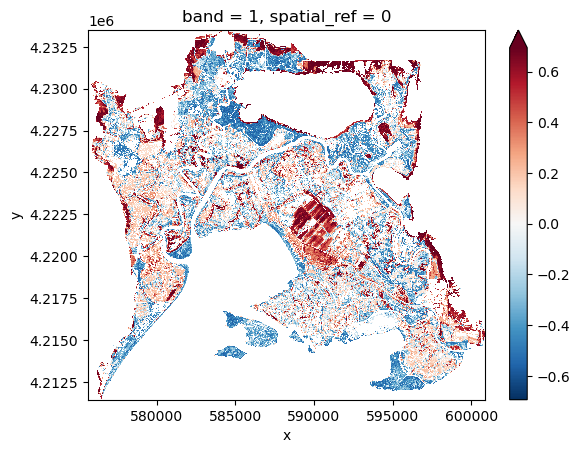

In [40]:
prediction.isel(band=0).plot(robust=True)

In [37]:
# mask out water 
import geopandas as gpd

# load shapefile to mask out the water
shp = gpd.read_file('SHP/Suisun_mask.shp')
# get the sjapefile geometry
shp_geom = shp.geometry

# mask out the water on first three bands
prediction_masked = prediction.isel(band=[0,1,2]).rio.clip(shp_geom, shp.crs, drop=False)
prediction_masked

<xarray.DataArray (band: 3, y: 2207, x: 2522)>
dask.array<where, shape=(3, 2207, 2522), dtype=float64, chunksize=(1, 350, 350), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 5.756e+05 5.757e+05 ... 6.008e+05 6.009e+05
  * y            (y) float64 4.233e+06 4.233e+06 ... 4.211e+06 4.211e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

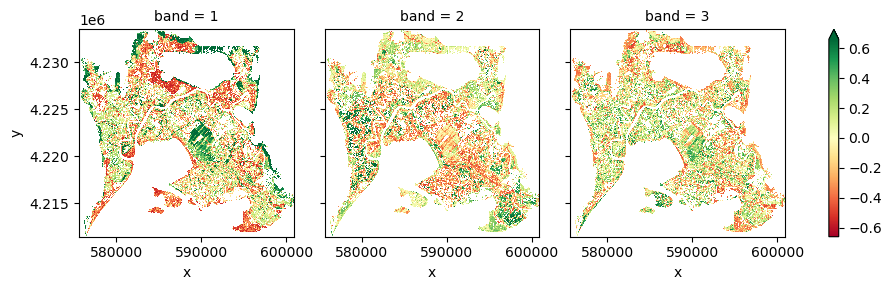

In [25]:
# RGB composition plot of the encoded data
prediction_masked.plot.imshow(col='band', col_wrap=3, cmap='RdYlGn', robust=True)
plt.savefig('figures/KernelPCA_components.png', dpi=300)

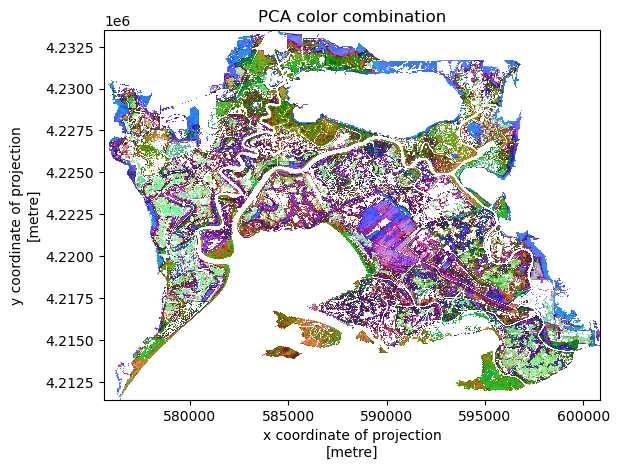

In [26]:
# RGB composition plot of the encoded data
prediction_masked[[2, 1, 0], :, :].plot.imshow(robust=True)
plt.title('PCA color combination')
plt.savefig('figures/KernelPCA_color_combination.png', dpi=300)

In [38]:
# save raster to disk
prediction_masked.rio.to_raster('Rasters/KernelPCA_clip.tif')

In [41]:
# delete the temporary files
!rm -r Rasters/tmp

In [ ]:
# rasterize shp using data as a template using gdal
!gdal_rasterize -a id -tr 10 10 -te 0 0 1000 1000 -ot Byte -of GTiff -co COMPRESS=LZW -co TILED=YES SHP/Suisun_.shp Rasters/Suisun_mask.tif
